# Load functions

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import keras_tuner as kt
import datetime
import os
import tensorflow as tf
import gc
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings


os.environ["KERAS_BACKEND"] = "tensorflow"

from prepData import prepData_STM, prepData_VGG, prepData_YAM, prepData_AST, prepData_melspectrogram, mask_STMmatrix



def eval_model(model, test_dataset):
    # search the max F1 score across thresholds
    macroF1_list = []
    for threshold in range(5,100,5):
        macroF1_list.append(keras.metrics.F1Score(average="macro", threshold=threshold/100, name="macro_f1_score_"+str(threshold), dtype=None))
    
    ROCAUC = keras.metrics.AUC(curve="ROC", name="ROC-AUC")
    PRAUC = keras.metrics.AUC(curve="PR", name="PR-AUC")
    
    model.compile(metrics=[ROCAUC, PRAUC,'accuracy']+macroF1_list)
    evaluation = model.evaluate(test_dataset)
    max_threshold = (np.argmax(evaluation[4:])+1)*0.05
    
    df_f1 = eval_model_classF1(model, test_dataset, max_threshold)
    
    flat_data = evaluation[:3] + [max(evaluation[4:])] + [evaluation[3]] +[max_threshold]
    # Define column names
    columns = ['loss', 'ROC-AUC', 'PR-AUC', 'max_macro_f1', 'accuracy', 'max_f1_threshold']
    # Create DataFrame
    df = pd.DataFrame([flat_data], columns=columns)
    df_all = pd.concat([df, df_f1], axis=1)
    return df_all

def eval_model_classF1(model, test_dataset, threshold):
    macroF1_list = []
    macroF1_list.append(keras.metrics.F1Score(average=None, threshold=threshold))
    
    model.compile(metrics=macroF1_list)
    evaluation = model.evaluate(test_dataset)
    columns = ['speech: nontonal', 'speech: tonal', 'music: vocal', 'music: nonvocal', 'env: urban', 'env: wildlife']
    df = pd.DataFrame([list(evaluation[1].numpy())], columns=columns)
    return df

def path_finder(base_path):
    # Define the base path and the pattern
    pattern = os.path.join(base_path, 'MLP_*/best_model0.keras')

    # Find all matching paths
    matching_paths = glob.glob(pattern)

    # Check if there are multiple matches
    if len(matching_paths) > 1:
        warnings.warn('Multiple paths found. Using the first one.')
    elif len(matching_paths) == 0:
        raise FileNotFoundError('No matching paths found.')
    else:
        return matching_paths[0]

2025-02-17 15:17:17.485853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# STM (PCA)

In [ ]:
_, _, test_dataset_STM, n_feat_STM, n_target = prepData_STM(n_pca=1024)
_, _, test_dataset_STM_ds, n_feat_STM, n_target = prepData_STM(ds_nontonal_speech=True, n_pca=1024)

model_STM_dropout_F1 = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/Dropout/macroF1"))
model_STM_dropout_AUC = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/Dropout/ROC-AUC"))
model_STM_LN_F1 = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/LayerNormalization/macroF1"))
model_STM_LN_AUC = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/LayerNormalization/ROC-AUC"))

model_STM_dropout_F1_ds = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/Dropout/macroF1/downsample"))
model_STM_dropout_AUC_ds = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/Dropout/ROC-AUC/downsample"))
model_STM_LN_F1_ds = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/LayerNormalization/macroF1/downsample"))
model_STM_LN_AUC_ds = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/LayerNormalization/ROC-AUC/downsample"))


In [ ]:
eval_STM_dropout_F1 = eval_model(model_STM_dropout_F1, test_dataset_STM)
eval_STM_dropout_F1['model'] = 'STM_dropout_F1'
eval_STM_dropout_AUC = eval_model(model_STM_dropout_AUC, test_dataset_STM)
eval_STM_dropout_AUC['model'] = 'STM_dropout_AUC'

eval_STM_LN_F1 = eval_model(model_STM_LN_F1, test_dataset_STM)
eval_STM_LN_F1['model'] = 'STM_LN_F1'
eval_STM_LN_AUC = eval_model(model_STM_LN_AUC, test_dataset_STM)
eval_STM_LN_AUC['model'] = 'STM_LN_AUC'

eval_STM_dropout_F1_ds = eval_model(model_STM_dropout_F1_ds, test_dataset_STM_ds)
eval_STM_dropout_F1_ds['model'] = 'STM_dropout_F1_ds'
eval_STM_dropout_AUC_ds = eval_model(model_STM_dropout_AUC_ds, test_dataset_STM_ds)
eval_STM_dropout_AUC_ds['model'] = 'STM_dropout_AUC_ds'

eval_STM_LN_F1_ds = eval_model(model_STM_LN_F1_ds, test_dataset_STM_ds)
eval_STM_LN_F1_ds['model'] = 'STM_LN_F1_ds'
eval_STM_LN_AUC_ds = eval_model(model_STM_LN_AUC_ds, test_dataset_STM_ds)
eval_STM_LN_AUC_ds['model'] = 'STM_LN_AUC_ds'

df_STM_eval = pd.concat([
    eval_STM_dropout_F1,
    eval_STM_dropout_AUC,
    eval_STM_LN_F1,
    eval_STM_LN_AUC,
    eval_STM_dropout_F1_ds,
    eval_STM_dropout_AUC_ds,
    eval_STM_LN_F1_ds,
    eval_STM_LN_AUC_ds,
    ], ignore_index=True)

time_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

df_STM_eval.to_csv("model/MLP_summary_STM_"+time_stamp+".csv", index=False)

# VGGish

In [ ]:
_, _, test_dataset_VGG, n_feat_VGG, n_target = prepData_VGG()
_, _, test_dataset_VGG_ds, n_feat_VGG, n_target = prepData_VGG(ds_nontonal_speech=True)


model_VGG_dropout_F1 = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/Dropout/macroF1"))
model_VGG_dropout_AUC = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/Dropout/ROC-AUC"))
model_VGG_LN_F1 = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/LayerNormalization/macroF1"))
model_VGG_LN_AUC = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/LayerNormalization/ROC-AUC"))

model_VGG_dropout_F1_ds = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/Dropout/macroF1/downsample"))
model_VGG_dropout_AUC_ds = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/Dropout/ROC-AUC/downsample"))
model_VGG_LN_F1_ds = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/LayerNormalization/macroF1/downsample"))
model_VGG_LN_AUC_ds = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/LayerNormalization/ROC-AUC/downsample"))


In [ ]:
eval_VGG_dropout_F1 = eval_model(model_VGG_dropout_F1, test_dataset_VGG)
eval_VGG_dropout_F1['model'] = 'VGG_dropout_F1'
eval_VGG_dropout_AUC = eval_model(model_VGG_dropout_AUC, test_dataset_VGG)
eval_VGG_dropout_AUC['model'] = 'VGG_dropout_AUC'

eval_VGG_LN_F1 = eval_model(model_VGG_LN_F1, test_dataset_VGG)
eval_VGG_LN_F1['model'] = 'VGG_LN_F1'
eval_VGG_LN_AUC = eval_model(model_VGG_LN_AUC, test_dataset_VGG)
eval_VGG_LN_AUC['model'] = 'VGG_LN_AUC'

eval_VGG_dropout_F1_ds = eval_model(model_VGG_dropout_F1_ds, test_dataset_VGG_ds)
eval_VGG_dropout_F1_ds['model'] = 'VGG_dropout_F1_ds'
eval_VGG_dropout_AUC_ds = eval_model(model_VGG_dropout_AUC_ds, test_dataset_VGG_ds)
eval_VGG_dropout_AUC_ds['model'] = 'VGG_dropout_AUC_ds'

eval_VGG_LN_F1_ds = eval_model(model_VGG_LN_F1_ds, test_dataset_VGG_ds)
eval_VGG_LN_F1_ds['model'] = 'VGG_LN_F1_ds'
eval_VGG_LN_AUC_ds = eval_model(model_VGG_LN_AUC_ds, test_dataset_VGG_ds)
eval_VGG_LN_AUC_ds['model'] = 'VGG_LN_AUC_ds'

df_VGG_eval = pd.concat([
    eval_VGG_dropout_F1,
    eval_VGG_dropout_AUC,
    eval_VGG_LN_F1,
    eval_VGG_LN_AUC,
    eval_VGG_dropout_F1_ds,
    eval_VGG_dropout_AUC_ds,
    eval_VGG_LN_F1_ds,
    eval_VGG_LN_AUC_ds,
    ], ignore_index=True)

time_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

df_VGG_eval.to_csv("model/MLP_summary_VGG_"+time_stamp+".csv", index=False)

# YAMNet

In [ ]:
_, _, test_dataset_YAM, n_feat_YAM, n_target = prepData_YAM()
_, _, test_dataset_YAM_ds, n_feat_YAM, n_target = prepData_YAM(ds_nontonal_speech=True)

model_YAM_dropout_F1 = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/Dropout/macroF1"))
model_YAM_dropout_AUC = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/Dropout/ROC-AUC"))
model_YAM_LN_F1 = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/LayerNormalization/macroF1"))
model_YAM_LN_AUC = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/LayerNormalization/ROC-AUC"))

model_YAM_dropout_F1_ds = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/Dropout/macroF1/downsample"))
model_YAM_dropout_AUC_ds = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/Dropout/ROC-AUC/downsample"))
model_YAM_LN_F1_ds = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/LayerNormalization/macroF1/downsample"))
model_YAM_LN_AUC_ds = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/LayerNormalization/ROC-AUC/downsample"))


In [ ]:
eval_YAM_dropout_F1 = eval_model(model_YAM_dropout_F1, test_dataset_YAM)
eval_YAM_dropout_F1['model'] = 'YAM_dropout_F1'
eval_YAM_dropout_AUC = eval_model(model_YAM_dropout_AUC, test_dataset_YAM)
eval_YAM_dropout_AUC['model'] = 'YAM_dropout_AUC'

eval_YAM_LN_F1 = eval_model(model_YAM_LN_F1, test_dataset_YAM)
eval_YAM_LN_F1['model'] = 'YAM_LN_F1'
eval_YAM_LN_AUC = eval_model(model_YAM_LN_AUC, test_dataset_YAM)
eval_YAM_LN_AUC['model'] = 'YAM_LN_AUC'

eval_YAM_dropout_F1_ds = eval_model(model_YAM_dropout_F1_ds, test_dataset_YAM_ds)
eval_YAM_dropout_F1_ds['model'] = 'YAM_dropout_F1_ds'
eval_YAM_dropout_AUC_ds = eval_model(model_YAM_dropout_AUC_ds, test_dataset_YAM_ds)
eval_YAM_dropout_AUC_ds['model'] = 'YAM_dropout_AUC_ds'

eval_YAM_LN_F1_ds = eval_model(model_YAM_LN_F1_ds, test_dataset_YAM_ds)
eval_YAM_LN_F1_ds['model'] = 'YAM_LN_F1_ds'
eval_YAM_LN_AUC_ds = eval_model(model_YAM_LN_AUC_ds, test_dataset_YAM_ds)
eval_YAM_LN_AUC_ds['model'] = 'YAM_LN_AUC_ds'

df_YAM_eval = pd.concat([
    eval_YAM_dropout_F1,
    eval_YAM_dropout_AUC,
    eval_YAM_LN_F1,
    eval_YAM_LN_AUC,
    eval_YAM_dropout_F1_ds,
    eval_YAM_dropout_AUC_ds,
    eval_YAM_LN_F1_ds,
    eval_YAM_LN_AUC_ds,
    ], ignore_index=True)

time_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

df_YAM_eval.to_csv("model/MLP_summary_YAM_"+time_stamp+".csv", index=False)

# Mel-Spectrogram (PCA)

In [ ]:
_, _, test_dataset_mel, n_feat_mel, n_target = prepData_melspectrogram(n_pca=1024)
_, _, test_dataset_mel_ds, n_feat_mel, n_target = prepData_melspectrogram(ds_nontonal_speech=True, n_pca=1024)

model_mel_dropout_F1 = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/Dropout/macroF1"))
model_mel_dropout_AUC = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/Dropout/ROC-AUC"))
model_mel_LN_F1 = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/LayerNormalization/macroF1"))
model_mel_LN_AUC = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/LayerNormalization/ROC-AUC"))

model_mel_dropout_F1_ds = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/Dropout/macroF1/downsample"))
model_mel_dropout_AUC_ds = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/Dropout/ROC-AUC/downsample"))
model_mel_LN_F1_ds = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/LayerNormalization/macroF1/downsample"))
model_mel_LN_AUC_ds = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/LayerNormalization/ROC-AUC/downsample"))


In [ ]:
eval_mel_dropout_F1 = eval_model(model_mel_dropout_F1, test_dataset_mel)
eval_mel_dropout_F1['model'] = 'mel_dropout_F1'
eval_mel_dropout_AUC = eval_model(model_mel_dropout_AUC, test_dataset_mel)
eval_mel_dropout_AUC['model'] = 'mel_dropout_AUC'

eval_mel_LN_F1 = eval_model(model_mel_LN_F1, test_dataset_mel)
eval_mel_LN_F1['model'] = 'mel_LN_F1'
eval_mel_LN_AUC = eval_model(model_mel_LN_AUC, test_dataset_mel)
eval_mel_LN_AUC['model'] = 'mel_LN_AUC'

eval_mel_dropout_F1_ds = eval_model(model_mel_dropout_F1_ds, test_dataset_mel_ds)
eval_mel_dropout_F1_ds['model'] = 'mel_dropout_F1_ds'
eval_mel_dropout_AUC_ds = eval_model(model_mel_dropout_AUC_ds, test_dataset_mel_ds)
eval_mel_dropout_AUC_ds['model'] = 'mel_dropout_AUC_ds'

eval_mel_LN_F1_ds = eval_model(model_mel_LN_F1_ds, test_dataset_mel_ds)
eval_mel_LN_F1_ds['model'] = 'mel_LN_F1_ds'
eval_mel_LN_AUC_ds = eval_model(model_mel_LN_AUC_ds, test_dataset_mel_ds)
eval_mel_LN_AUC_ds['model'] = 'mel_LN_AUC_ds'

df_mel_eval = pd.concat([
    eval_mel_dropout_F1,
    eval_mel_dropout_AUC,
    eval_mel_LN_F1,
    eval_mel_LN_AUC,
    eval_mel_dropout_F1_ds,
    eval_mel_dropout_AUC_ds,
    eval_mel_LN_F1_ds,
    eval_mel_LN_AUC_ds,
    ], ignore_index=True)

time_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

df_mel_eval.to_csv("model/MLP_summary_mel_"+time_stamp+".csv", index=False)

# AST

In [3]:
_, _, test_dataset_AST, n_feat_AST, n_target = prepData_AST()
_, _, test_dataset_AST_ds, n_feat_AST, n_target = prepData_AST(ds_nontonal_speech=True)

model_AST_dropout_F1 = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/Dropout/macroF1"))
model_AST_dropout_AUC = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/Dropout/ROC-AUC"))
model_AST_LN_F1 = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/LayerNormalization/macroF1"))
model_AST_LN_AUC = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/LayerNormalization/ROC-AUC"))

model_AST_dropout_F1_ds = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/Dropout/macroF1/downsample"))
model_AST_dropout_AUC_ds = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/Dropout/ROC-AUC/downsample"))
model_AST_LN_F1_ds = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/LayerNormalization/macroF1/downsample"))
model_AST_LN_AUC_ds = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/LayerNormalization/ROC-AUC/downsample"))

ast_output/embeddings/BibleTTS-akuapem-twi_astEmbeddings.npy
ast_output/embeddings/BibleTTS-asante-twi_astEmbeddings.npy
ast_output/embeddings/BibleTTS-ewe_astEmbeddings.npy
ast_output/embeddings/BibleTTS-hausa_astEmbeddings.npy
ast_output/embeddings/BibleTTS-lingala_astEmbeddings.npy
ast_output/embeddings/BibleTTS-yoruba_astEmbeddings.npy
ast_output/embeddings/Buckeye_astEmbeddings.npy
ast_output/embeddings/EUROM_astEmbeddings.npy
ast_output/embeddings/HiltonMoser2022_speech_astEmbeddings.npy
ast_output/embeddings/LibriSpeech_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-AR_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-ES_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-FR_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-TR_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ab_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ar_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ba_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-be

/Users/andrewchang/NYU_research/MusicSpeech-STM/prepData.py:543: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target.replace({


Good to go!
ast_output/embeddings/BibleTTS-akuapem-twi_astEmbeddings.npy
ast_output/embeddings/BibleTTS-asante-twi_astEmbeddings.npy
ast_output/embeddings/BibleTTS-ewe_astEmbeddings.npy
ast_output/embeddings/BibleTTS-hausa_astEmbeddings.npy
ast_output/embeddings/BibleTTS-lingala_astEmbeddings.npy
ast_output/embeddings/BibleTTS-yoruba_astEmbeddings.npy
ast_output/embeddings/Buckeye_astEmbeddings.npy
ast_output/embeddings/EUROM_astEmbeddings.npy
ast_output/embeddings/HiltonMoser2022_speech_astEmbeddings.npy
ast_output/embeddings/LibriSpeech_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-AR_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-ES_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-FR_astEmbeddings.npy
ast_output/embeddings/MediaSpeech-TR_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ab_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ar_astEmbeddings.npy
ast_output/embeddings/MozillaCommonVoice-ba_astEmbeddings.npy
ast_output/embeddings/MozillaCo

/Users/andrewchang/NYU_research/MusicSpeech-STM/prepData.py:543: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target.replace({


Embedding data and meta data mismatched!


In [4]:
eval_AST_dropout_F1 = eval_model(model_AST_dropout_F1, test_dataset_AST)
eval_AST_dropout_F1['model'] = 'AST_dropout_F1'
eval_AST_dropout_AUC = eval_model(model_AST_dropout_AUC, test_dataset_AST)
eval_AST_dropout_AUC['model'] = 'AST_dropout_AUC'

eval_AST_LN_F1 = eval_model(model_AST_LN_F1, test_dataset_AST)
eval_AST_LN_F1['model'] = 'AST_LN_F1'
eval_AST_LN_AUC = eval_model(model_AST_LN_AUC, test_dataset_AST)
eval_AST_LN_AUC['model'] = 'AST_LN_AUC'

eval_AST_dropout_F1_ds = eval_model(model_AST_dropout_F1_ds, test_dataset_AST_ds)
eval_AST_dropout_F1_ds['model'] = 'AST_dropout_F1_ds'
eval_AST_dropout_AUC_ds = eval_model(model_AST_dropout_AUC_ds, test_dataset_AST_ds)
eval_AST_dropout_AUC_ds['model'] = 'AST_dropout_AUC_ds'

eval_AST_LN_F1_ds = eval_model(model_AST_LN_F1_ds, test_dataset_AST_ds)
eval_AST_LN_F1_ds['model'] = 'AST_LN_F1_ds'
eval_AST_LN_AUC_ds = eval_model(model_AST_LN_AUC_ds, test_dataset_AST_ds)
eval_AST_LN_AUC_ds['model'] = 'AST_LN_AUC_ds'

df_AST_eval = pd.concat([
    eval_AST_dropout_F1,
    eval_AST_dropout_AUC,
    eval_AST_LN_F1,
    eval_AST_LN_AUC,
    eval_AST_dropout_F1_ds,
    eval_AST_dropout_AUC_ds,
    eval_AST_LN_F1_ds,
    eval_AST_LN_AUC_ds,
    ], ignore_index=True)

time_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

df_AST_eval.to_csv("model/MLP_summary_AST_"+time_stamp+".csv", index=False)

414/414 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - PR-AUC: 0.9747 - ROC-AUC: 0.9949 - accuracy: 0.9171 - loss: 7.6654e-04 - macro_f1_score_10: 0.7604 - macro_f1_score_15: 0.7883 - macro_f1_score_20: 0.8117 - macro_f1_score_25: 0.8336 - macro_f1_score_30: 0.8518 - macro_f1_score_35: 0.8667 - macro_f1_score_40: 0.8782 - macro_f1_score_45: 0.8811 - macro_f1_score_5: 0.7219 - macro_f1_score_50: 0.8705 - macro_f1_score_55: 0.8429 - macro_f1_score_60: 0.8069 - macro_f1_score_65: 0.7687 - macro_f1_score_70: 0.7336 - macro_f1_score_75: 0.7020 - macro_f1_score_80: 0.6635 - macro_f1_score_85: 0.6046 - macro_f1_score_90: 0.4925 - macro_f1_score_95: 0.2532
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - f1_score: 0.8829 - loss: 7.6654e-04
414/414 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - PR-AUC: 0.9735 - ROC-AUC: 0.9947 - accuracy: 0.9195 - loss: 0.0187 - macro_f1_score_10: 0.7615 - macro_f1_score_15: 0.7925 - macro_f1_score_20: 0.8186 - macro_f1_score_25: 0.8390 - macro_f1_score_30: 0.8555 - macro_f1_score_35: 0

# STM ablation study

In [2]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from prepData import corpora_list

def prepData_STM_numpy():
    # % load STM data
    corpus_list_all = corpora_list(addAug=False)
    
    for corp in corpus_list_all:
        filename = 'STM_output/corpSTMnpy/'+corp.replace('/', '-')+'_STMall.npy'
        if 'STM_all' not in locals():
            STM_all = np.load(filename)
        else:
            STM_all = np.vstack((STM_all, np.load(filename)))
        print(filename)
        
    # % load meta data
    speech_corp_df1 = pd.read_csv('train_test_split/speech1_10folds_speakerGroupFold.csv',index_col=0)
    speech_corp_df2 = pd.read_csv('train_test_split/speech2_10folds_speakerGroupFold.csv',index_col=0)
    music_corp_df = pd.read_csv('train_test_split/music_10folds_speakerGroupFold.csv',index_col=0)
    df_SONYC = pd.read_csv('train_test_split/env_10folds_speakerGroupFold.csv',index_col=0)
    
    all_corp_df = pd.concat([speech_corp_df1, speech_corp_df2, music_corp_df, df_SONYC], ignore_index=True)

    target = all_corp_df['corpus_type']
    data_split = all_corp_df['10fold_labels']
    
    target.replace({
        'speech: non-tonal':0,
        'speech: tonal':1,
        'music: vocal':2,
        'music: non-vocal':3,
        'env: urban':4,
        'env: wildlife':5,
        },
        inplace=True)
    
    return STM_all, target, data_split

def filter_STM(STM_all, target, data_split, ablation_params, n_pca=None):
    
    mask_matrix = mask_STMmatrix(ablation_params).flatten()
    # np.random.seed(23)
    # STM_all[:, mask_matrix==1] = np.random.rand(STM_all.shape[0], np.sum(mask_matrix))
    # STM_all[:, mask_matrix==1] = 0.0 # put the filtered out regions as 0
    STM_all = STM_all[:,mask_matrix==0] # exclude the filtered out regions (Sept 6)
    del mask_matrix
    
    y = keras.utils.to_categorical(target, num_classes=len(target.unique()))
       
        
    # % split data
    train_ind = data_split<8
    val_ind = data_split==8
    test_ind = data_split==9
    
    # add PCA
    if n_pca is not None:
        n_feat = n_pca
        pipeline = make_pipeline(StandardScaler(),IncrementalPCA(n_components=n_pca))
    else:
        n_feat = STM_all.shape[1]
        pipeline = make_pipeline(StandardScaler())
    
    
    train_dataset = tf.data.Dataset.from_tensor_slices((pipeline.fit_transform(STM_all[train_ind,:]), y[train_ind,:]))
    val_dataset = tf.data.Dataset.from_tensor_slices((pipeline.transform(STM_all[val_ind,:]), y[val_ind,:]))
    test_dataset = tf.data.Dataset.from_tensor_slices((pipeline.transform(STM_all[test_ind,:]), y[test_ind,:]))

    
    # shuffle and then batch
    batch_size = 256

    train_dataset = train_dataset.shuffle(buffer_size=sum(train_ind), seed=23).batch(batch_size)
    val_dataset = val_dataset.shuffle(buffer_size=sum(val_ind), seed=23).batch(batch_size)
    test_dataset = test_dataset.shuffle(buffer_size=sum(test_ind), seed=23).batch(batch_size)
    
    n_target = len(target.unique())
    
   
    if len(target) != len(STM_all):
        print("STM data and meta data mismatched!")
    elif sum(train_ind)+sum(val_ind)+sum(test_ind) != len(STM_all):
        print("Data split wrong")
    else:
        print("Good to go!")
        
    return train_dataset, val_dataset, test_dataset, n_feat, n_target

def load_ablation_keras(highlow, xcutoff, ycutoff, STM_all, target, data_split):
    # load model
    cond = 'x'+highlow+'cutoff'+str(xcutoff)+'_y'+highlow+'cutoff'+str(ycutoff)
    filename = glob.glob('model/STM/MLP_corpora_categories/PCA/Dropout/macroF1/ablation/'+cond+'/**/best_model0.keras')[0]
    model = keras.saving.load_model(filename)
    
    # load data
    if highlow=='high':
        ablation_params = {
            'x_lowcutoff': None,
            'x_highcutoff': xcutoff,
            'y_lowcutoff': None,
            'y_highcutoff': ycutoff,
            }
    elif highlow=='low':
        ablation_params = {
            'x_lowcutoff': xcutoff,
            'x_highcutoff': None,
            'y_lowcutoff': ycutoff,
            'y_highcutoff': None,
            }
    # _, _, test_dataset_STM, n_feat_STM, n_target = prepData_STM(ablation_params=ablation_params)
    _, _, test_dataset_STM, _, _ = filter_STM(STM_all, target, data_split, ablation_params)
    
    # run model
    df = eval_model(model, test_dataset_STM)
    df['highlow'] = highlow
    df['xcutoff'] = xcutoff
    df['ycutoff'] = ycutoff
    return df


In [ ]:
# %% ablation models evaluation
ablation_df_list = []
STM_all, target, data_split = prepData_STM_numpy() # load the overall data one time

for highlow in ['high','low']:
    for xcutoff in range(7):
        for ycutoff in range(7):
            ablation_df_list.append(load_ablation_keras(highlow, xcutoff, ycutoff, STM_all, target, data_split))
            
# pd.concat(ablation_df_list).to_csv("model/MLP_STM_ablation_20250120.csv", index=False)


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_16113/3104369054.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to fit the colorbar


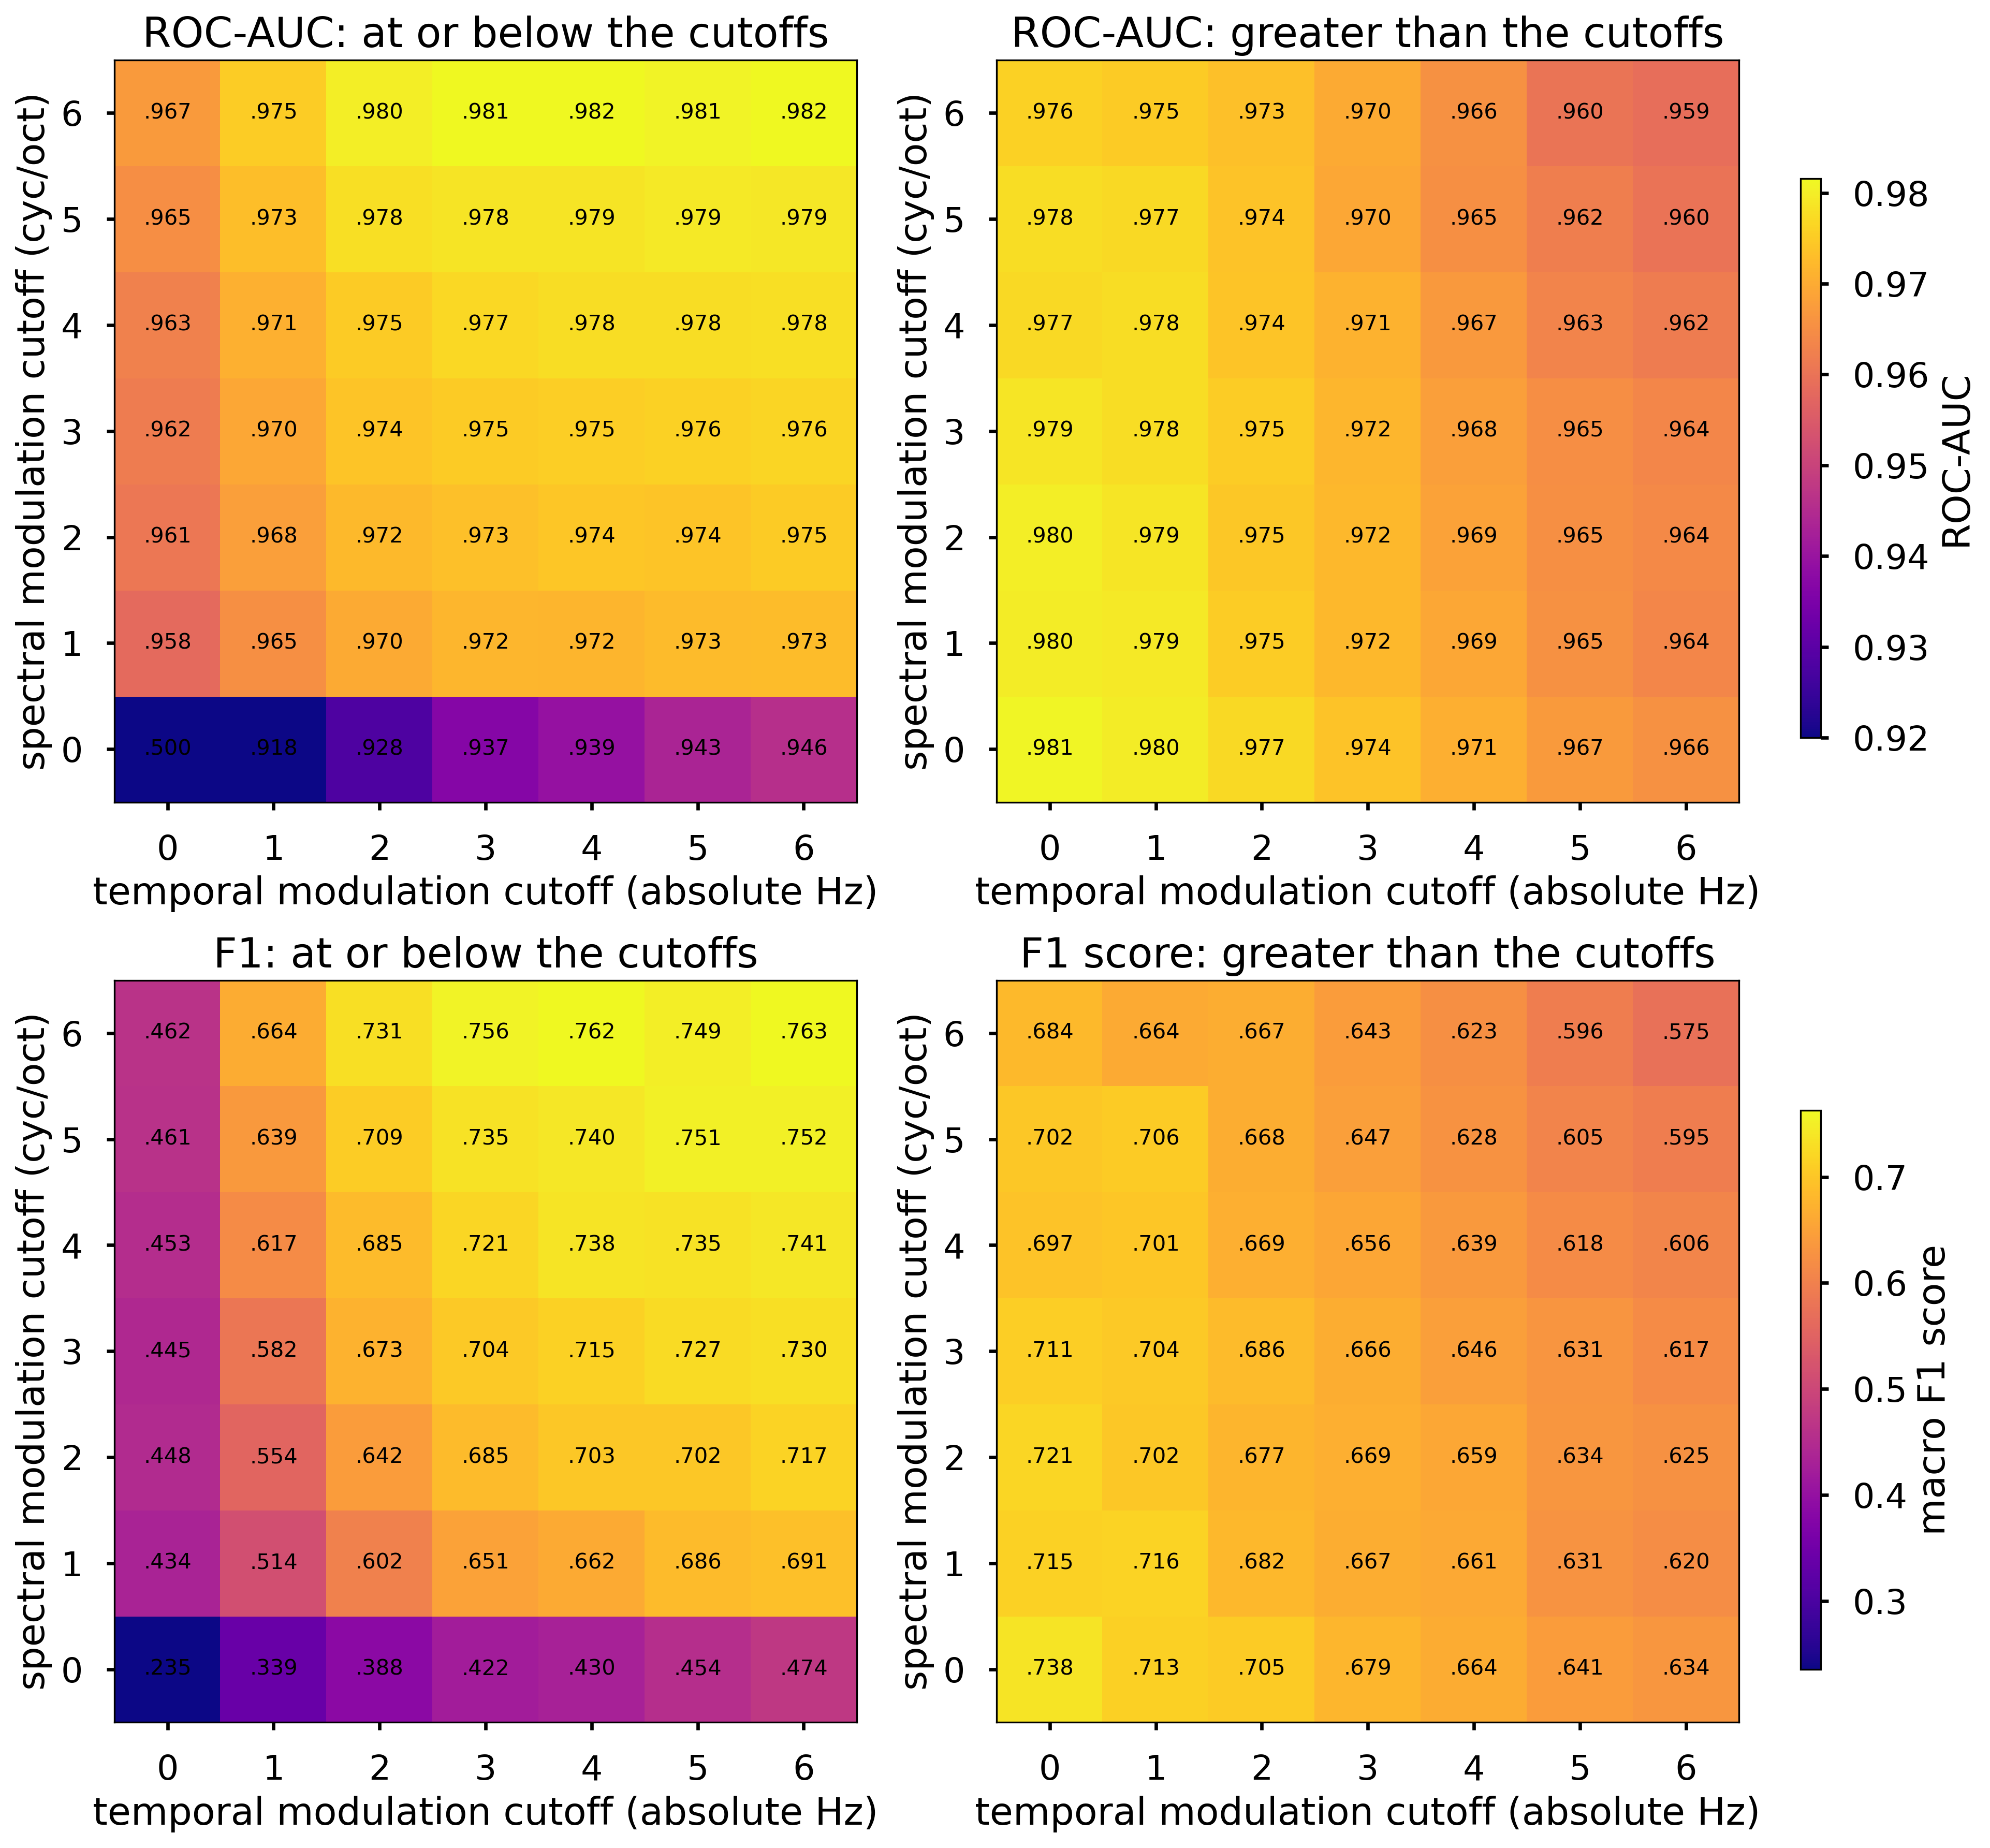

In [5]:
df = pd.read_csv("model/MLP_STM_ablation_20250120.csv")
table_low_ROCAUC = pd.pivot_table(df[df['highlow']=='low'], values='ROC-AUC', index=['xcutoff'],  columns=['ycutoff'])
table_high_ROCAUC = pd.pivot_table(df[df['highlow']=='high'], values='ROC-AUC', index=['xcutoff'],  columns=['ycutoff'])
table_low_F1 = pd.pivot_table(df[df['highlow']=='low'], values='max_macro_f1', index=['xcutoff'],  columns=['ycutoff'])
table_high_F1 = pd.pivot_table(df[df['highlow']=='high'], values='max_macro_f1', index=['xcutoff'],  columns=['ycutoff'])


def show_values(data, ax):
    for (j, i), val in np.ndenumerate(data):
        ax.text(i,j,f'{val:.3f}'[1:],ha='center',va='center')

with plt.style.context('seaborn-v0_8-poster'):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(2, 2, figsize=(13, 12))
    
    centers = [0,6,0,6]
    dx, = np.diff(centers[:2])/(7-1)
    dy, = -np.diff(centers[2:])/(7-1)
    extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]
    
    # extent = [0, 6, 0, 6]
    cmap='plasma'
    
    # Plot ROC-AUC
    # min_ROCAUC = np.min(pd.concat([table_high_ROCAUC, table_low_ROCAUC]))
    min_ROCAUC = 0.92
    max_ROCAUC = np.max(pd.concat([table_high_ROCAUC, table_low_ROCAUC]))
    # norm_ROCAUC = mcolors.LogNorm(vmin=min_ROCAUC, vmax=max_ROCAUC, clip=True)
    
    im0 = ax[0,0].imshow(table_high_ROCAUC, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, vmin=min_ROCAUC, vmax=max_ROCAUC)
    # im0 = ax[0,0].imshow(table_high_ROCAUC, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, norm=norm_ROCAUC)
    ax[0,0].set_title('ROC-AUC: at or below the cutoffs')
    ax[0,0].set_xlabel('temporal modulation cutoff (absolute Hz)')
    ax[0,0].set_ylabel('spectral modulation cutoff (cyc/oct)')
    show_values(table_high_ROCAUC, ax[0,0])
    
    im1 = ax[0,1].imshow(table_low_ROCAUC, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, vmin=min_ROCAUC, vmax=max_ROCAUC)
    # im1 = ax[0,1].imshow(table_low_ROCAUC, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, norm=norm_ROCAUC)
    ax[0,1].set_title('ROC-AUC: greater than the cutoffs')
    ax[0,1].set_xlabel('temporal modulation cutoff (absolute Hz)')
    # ax[0,1].set_yticks([])
    ax[0,1].set_ylabel('spectral modulation cutoff (cyc/oct)')
    show_values(table_low_ROCAUC, ax[0,1])
    
    cbar_rocauc_ax = fig.add_axes([0.9, 0.6, 0.01, 0.3]) 
    cbar_rocauc = plt.colorbar(im1, cax=cbar_rocauc_ax)
    cbar_rocauc.set_label('ROC-AUC')

    
    
    # Plot F1
    min_f1 = np.min(pd.concat([table_high_F1, table_low_F1]))
    max_f1 = np.max(pd.concat([table_high_F1, table_low_F1]))
    norm_F1 = mcolors.LogNorm(vmin=min_f1, vmax=max_f1)
    
    im2 = ax[1,0].imshow(table_high_F1, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, vmin=min_f1, vmax=max_f1)
    # im2 = ax[1,0].imshow(table_high_F1, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, norm=norm_F1)
    ax[1,0].set_title('F1: at or below the cutoffs')
    ax[1,0].set_xlabel('temporal modulation cutoff (absolute Hz)')
    ax[1,0].set_ylabel('spectral modulation cutoff (cyc/oct)')
    show_values(table_high_F1, ax[1,0])
    
    im3 = ax[1,1].imshow(table_low_F1, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, vmin=min_f1, vmax=max_f1)
    # im3 = ax[1,1].imshow(table_low_F1, aspect='equal', origin='lower', extent=extent, cmap=cmap, interpolation=None, norm=norm_F1)
    ax[1,1].set_title('F1 score: greater than the cutoffs')
    ax[1,1].set_xlabel('temporal modulation cutoff (absolute Hz)')
    # ax[1,1].set_yticks([])
    ax[1,1].set_ylabel('spectral modulation cutoff (cyc/oct)')
    show_values(table_low_F1, ax[1,1])
    
    cbar_f1_ax = fig.add_axes([0.9, 0.1, 0.01, 0.3]) 
    cbar_f1 = plt.colorbar(im2, cax=cbar_f1_ax)
    cbar_f1.set_label('macro F1 score')

    
    
    # Adjust layout to make room for the colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to fit the colorbar
    plt.show()
    fig.savefig('ablation_20250120.png')


# Plot model performances

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [18]:
# Load the CSV file into a DataFrame

files = [
    'model/MLP_summary_STM_2025-01-11_09-44.csv',
    'model/MLP_summary_AST_2025-01-22_15-24.csv',
    'model/MLP_summary_YAM_2025-01-11_09-52.csv',
    'model/MLP_summary_VGG_2025-01-11_09-46.csv',
    'model/MLP_summary_mel_2025-01-11_11-15.csv'
]

features = ['STM', 'AST', 'YAM', 'VGG', 'Mel']

df_list = []
for file, feature in zip(files, features):
    df = pd.read_csv(file)

    # Filter the rows where the 'model' column contains 'dropout_F1'
    filtered_df = df[df['model'].str.contains('dropout_F1')].copy()
    filtered_df['Feature'] = feature
    filtered_df['undersampling'] = None
    filtered_df.loc[filtered_df.index[0], 'undersampling'] = 'No'
    filtered_df.loc[filtered_df.index[1], 'undersampling'] = 'Yes'

    df_list.append(filtered_df)
    
df = pd.concat(df_list, ignore_index=True)
df

,loss,ROC-AUC,PR-AUC,max_macro_f1,accuracy,max_f1_threshold,speech: nontonal,speech: tonal,music: vocal,music: nonvocal,env: urban,env: wildlife,model,Feature,undersampling
0,3.325653e-02,0.987658,0.937339,0.807883,0.876178,0.40,0.938288,0.675835,0.813741,0.638148,0.901520,0.879768,STM_dropout_F1,STM,No
1,2.478413e-02,0.972959,0.869273,0.806897,0.786117,0.45,0.790040,0.817583,0.815574,0.635404,0.893891,0.888889,STM_dropout_F1_ds,STM,Yes
2,7.665361e-04,0.994975,0.975278,0.883500,0.919613,0.45,0.969925,0.816210,0.835444,0.702217,0.992843,0.984361,AST_dropout_F1,AST,No
3,8.092088e-04,0.985589,0.929813,0.874963,0.847333,0.45,0.861934,0.882130,0.841963,0.708774,0.977543,0.977435,AST_dropout_F1_ds,AST,Yes
4,2.839596e-08,0.990403,0.952456,0.849344,0.894749,0.45,0.948337,0.690117,0.848226,0.736541,0.907471,0.965374,YAM_dropout_F1,YAM,No
5,6.114473e-05,0.979819,0.905485,0.835224,0.820356,0.45,0.795102,0.819175,0.860157,0.738605,0.832962,0.965344,YAM_dropout_F1_ds,YAM,Yes
6,1.068164e-02,0.993051,0.966389,0.870674,0.911781,0.45,0.957955,0.759067,0.856308,0.741386,0.937458,0.971868,VGG_dropout_F1,VGG,No
7,1.179398e-02,0.983762,0.922617,0.861817,0.838348,0.45,0.821998,0.841764,0.862586,0.748993,0.923181,0.972382,VGG_dropout_F1_ds,VGG,Yes
8,4.410300e-02,0.943566,0.739751,0.478501,0.760434,0.30,0.878358,0.299634,0.699546,0.345780,0.000000,0.647690,mel_dropout_F1,Mel,No
9,3.659666e-02,0.900236,0.587665,0.529741,0.560375,0.30,0.567845,0.692053,0.724923,0.444906,0.000000,0.748716,mel_dropout_F1_ds,Mel,Yes


In [92]:
df_melted = df.melt(
    id_vars=['Feature', 'undersampling'],
    value_vars=['speech: nontonal', 'speech: tonal', 'music: vocal', 'music: nonvocal', 'env: urban', 'env: wildlife'],
    var_name='Category',
    value_name='Value'
)

df_melted

,Feature,undersampling,Category,Value
0,STM,No,speech: nontonal,0.938288
1,STM,Yes,speech: nontonal,0.790040
2,AST,No,speech: nontonal,0.969925
3,AST,Yes,speech: nontonal,0.861934
4,YAM,No,speech: nontonal,0.948337
5,YAM,Yes,speech: nontonal,0.795102
6,VGG,No,speech: nontonal,0.957955
7,VGG,Yes,speech: nontonal,0.821998
8,Mel,No,speech: nontonal,0.878358
9,Mel,Yes,speech: nontonal,0.567845


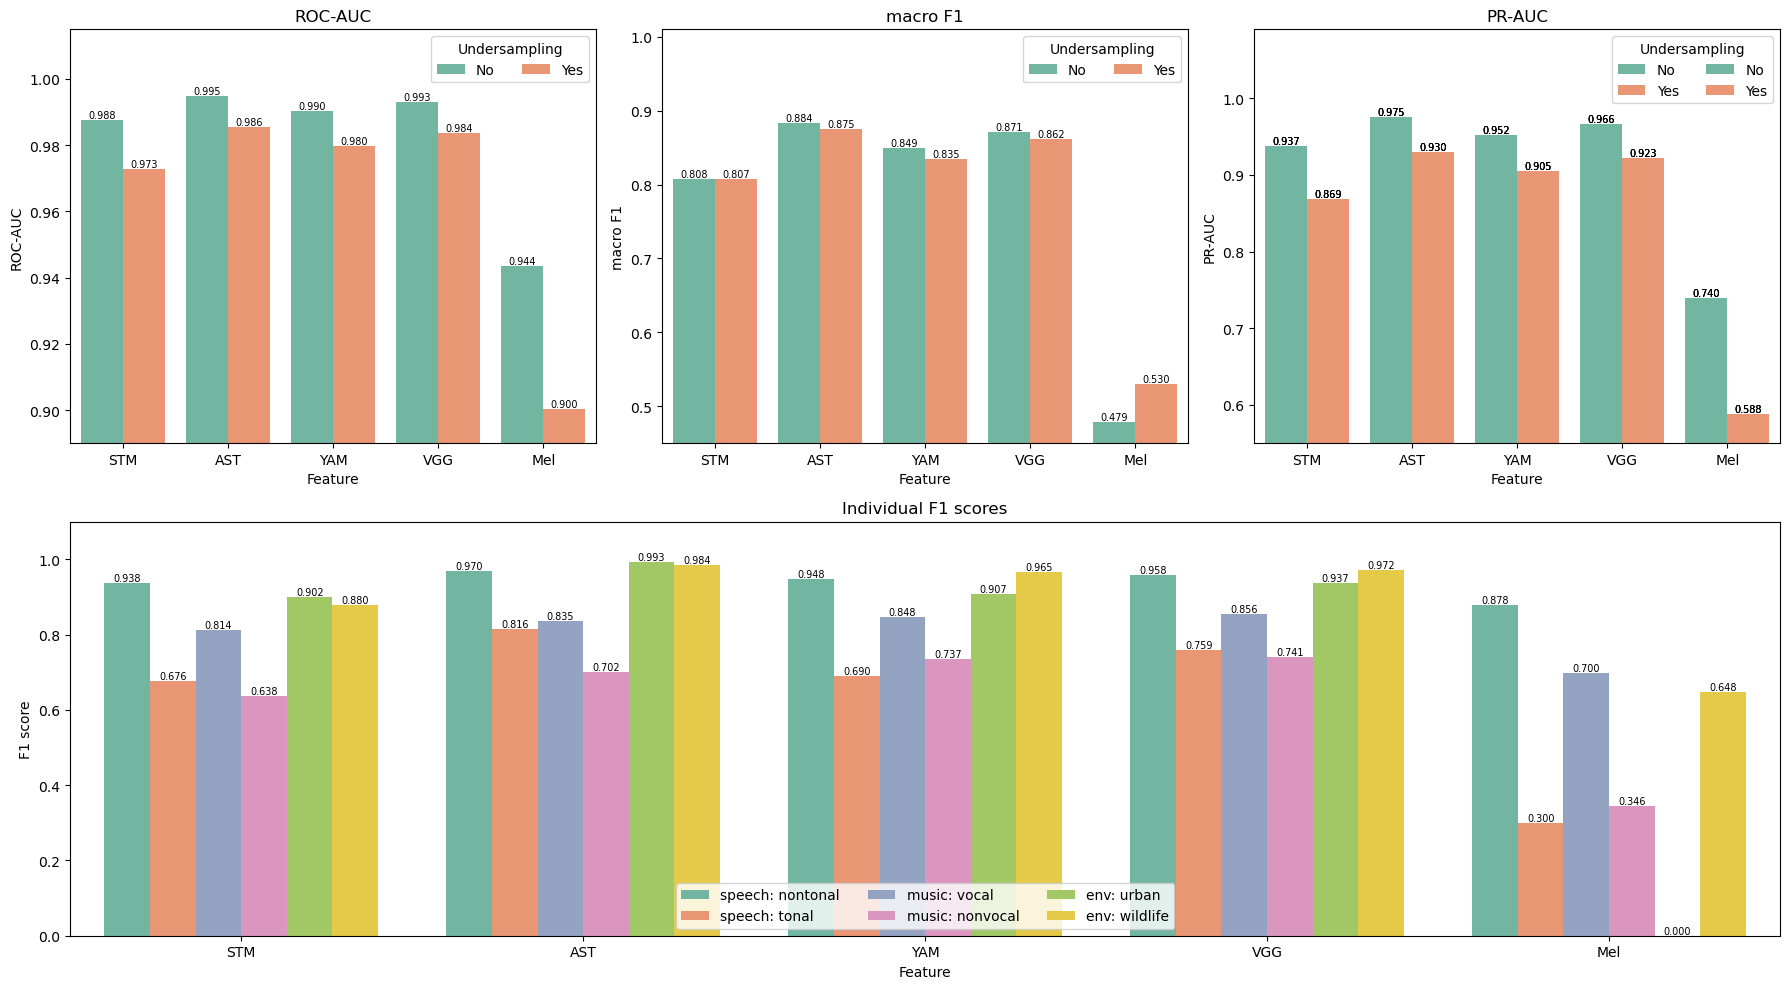

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

sns.barplot(y='ROC-AUC', hue='undersampling', x='Feature', data=df, palette='Set2', ax=axes[0])
axes[0].set_ylabel('ROC-AUC')
axes[0].set_xlabel('Feature')
axes[0].legend(loc='upper right', title='Undersampling', ncols=2)
axes[0].set_title('ROC-AUC')
axes[0].set_ylim(0.89, 1.015)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', label_type='edge', fontsize=7)
    
sns.barplot(y='max_macro_f1', hue='undersampling', x='Feature', data=df, palette='Set2', ax=axes[1])
axes[1].set_ylabel('macro F1')
axes[1].set_xlabel('Feature')
axes[1].legend(loc='upper right', title='Undersampling', ncols=2)
axes[1].set_title('macro F1')
axes[1].set_ylim(0.45, 1.01)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', label_type='edge', fontsize=7)
    
sns.barplot(y='PR-AUC', hue='undersampling', x='Feature', data=df, palette='Set2', ax=axes[2])
axes[2].set_ylabel('PR-AUC')
axes[2].set_xlabel('Feature')
axes[2].legend(loc='upper right', title='Undersampling', ncols=2)
axes[2].set_title('PR-AUC')
axes[2].set_ylim(0.55, 1.09)
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.3f', label_type='edge', fontsize=7)
    
sns.barplot(y='PR-AUC', hue='undersampling', x='Feature', data=df, palette='Set2', ax=axes[2])
axes[2].set_ylabel('PR-AUC')
axes[2].set_xlabel('Feature')
axes[2].legend(loc='upper right', title='Undersampling', ncols=2)
axes[2].set_title('PR-AUC')
axes[2].set_ylim(0.55, 1.09)
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.3f', label_type='edge', fontsize=7)


# Remove the existing subplots that will be combined
for i in range(3, 6):
    fig.delaxes(axes[i])
     
# Create a subplot that spans axes[3:5]
ax_combined = fig.add_subplot(2, 3, (4, 6))

# Plot the melted DataFrame across the combined subplot
sns.barplot(y='Value', hue='Category', x='Feature', data=df_melted[df_melted['undersampling']=='No'], palette='Set2', ax=ax_combined)
ax_combined.set_ylabel('F1 score')
ax_combined.set_xlabel('Feature')
ax_combined.legend(loc='lower center', ncols=3)
ax_combined.set_title('Individual F1 scores')
ax_combined.set_ylim(0, 1.1)
for container in ax_combined.containers:
    ax_combined.bar_label(container, fmt='%.3f', label_type='edge', fontsize=7)

plt.tight_layout()
plt.show()

In [115]:
model_STM_dropout_F1 = keras.saving.load_model(path_finder("model/STM/MLP_corpora_categories/PCA/Dropout/macroF1"))
model_VGG_dropout_F1 = keras.saving.load_model(path_finder("model/VGGish/MLP_corpora_categories/Dropout/macroF1"))
model_YAM_dropout_F1 = keras.saving.load_model(path_finder("model/YAMNet/MLP_corpora_categories/Dropout/macroF1"))
model_mel_dropout_F1 = keras.saving.load_model(path_finder("model/melspectrogram_norm_nan/MLP_corpora_categories/PCA/Dropout/macroF1"))
model_AST_dropout_F1 = keras.saving.load_model(path_finder("model/AST/MLP_corpora_categories/Dropout/macroF1"))


In [116]:
model_STM_dropout_F1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,263,386 (20.08 MB)

 Trainable params: 1,315,846 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,947,540 (15.06 MB)

In [117]:
model_VGG_dropout_F1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428,378 (13.08 MB)

 Trainable params: 857,094 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,571,284 (9.81 MB)

In [118]:
model_YAM_dropout_F1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,295,386 (12.57 MB)

 Trainable params: 823,846 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,471,540 (9.43 MB)

In [119]:
model_AST_dropout_F1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288)            │       147,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,824,218 (10.77 MB)

 Trainable params: 706,054 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,118,164 (8.08 MB)

In [121]:
cond = 'xhighcutoff4_yhighcutoff6'
filename = glob.glob('model/STM/MLP_corpora_categories/PCA/Dropout/macroF1/ablation/'+cond+'/**/best_model0.keras')[0]
model = keras.saving.load_model(filename)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,315,162 (16.46 MB)

 Trainable params: 1,078,790 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,236,372 (12.35 MB)